In [8]:
import os
import json
import random
import torch
from PIL import Image, ImageDraw, ImageFilter
import matplotlib.pyplot as plt

from datasets import Dataset
from transformers import AutoProcessor, AutoModelForImageTextToText
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
os.makedirs("data/images/checked", exist_ok=True)
os.makedirs("data/images/unchecked", exist_ok=True)
os.makedirs("data/images/ambiguous", exist_ok=True)

In [10]:
IMG_SIZE = 224
BOX_SIZE = 120

samples = {
    "checked": 100,
    "unchecked": 100,
    "ambiguous": 50
}

annotations = []

def generate_checkbox(state, idx):
    img = Image.new("RGB", (IMG_SIZE, IMG_SIZE), "white")
    draw = ImageDraw.Draw(img)

    x1 = (IMG_SIZE - BOX_SIZE) // 2
    y1 = (IMG_SIZE - BOX_SIZE) // 2
    x2, y2 = x1 + BOX_SIZE, y1 + BOX_SIZE
    draw.rectangle([x1, y1, x2, y2], outline="black", width=4)

    if state == "checked":
        draw.line([(x1+20,y1+60),(x1+50,y1+90),(x1+100,y1+30)], fill="black", width=6)

    elif state == "ambiguous":
        draw.line([(x1+40,y1+60),(x1+70,y1+50)], fill="black", width=4)
        img = img.filter(ImageFilter.GaussianBlur(1.5))

    img = img.rotate(random.uniform(-5, 5), fillcolor="white")
    return img

for state, count in samples.items():
    for i in range(count):
        img = generate_checkbox(state, i)
        path = f"data/images/{state}/{state}_{i}.png"
        img.save(path)

        annotations.append({
            "image": path,
            "label": state
        })

with open("data/annotations.json", "w") as f:
    json.dump(annotations, f, indent=2)

print("Dataset created successfully")

Dataset created successfully


(-0.5, 223.5, 223.5, -0.5)

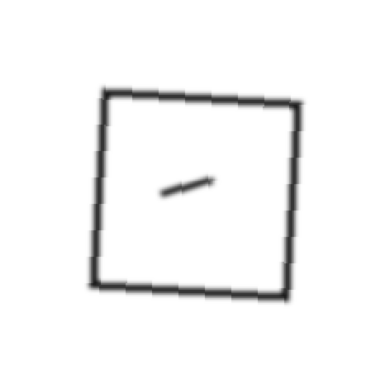

In [11]:
img = Image.open("data/images/ambiguous/ambiguous_0.png")
plt.imshow(img)
plt.axis("off")

In [12]:
model_name = "Qwen/Qwen2-VL-2B-Instruct"

processor = AutoProcessor.from_pretrained(
    model_name,
    use_fast=False
)

model = AutoModelForImageTextToText.from_pretrained(
    model_name,
    dtype=torch.float32,
    device_map="cpu"
)

print("Model loaded successfully")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded successfully


In [13]:
def predict_checkbox(image_path):
    image = Image.open(image_path).convert("RGB")

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {
                    "type": "text",
                    "text": "Classify the checkbox state. Answer with one word: checked, unchecked, or ambiguous."
                }
            ]
        }
    ]

    prompt = processor.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = processor(
        text=prompt,
        images=image,
        return_tensors="pt"
    )

    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=5)

    result = processor.decode(output[0], skip_special_tokens=True)
    return result.strip().lower()

In [14]:
test_img = "data/images/checked/checked_0.png"
print("Prediction:", predict_checkbox(test_img))

Prediction: system
you are a helpful assistant.
user
classify the checkbox state. answer with one word: checked, unchecked, or ambiguous.
assistant
checked


In [15]:
y_true = []
y_pred = []

for sample in random.sample(annotations, 30):
    pred = predict_checkbox(sample["image"])
    y_true.append(sample["label"])
    y_pred.append(pred)

print(classification_report(y_true, y_pred))

                                                                                                                                                 precision    recall  f1-score   support

                                                                                                                                      ambiguous       0.00      0.00      0.00      10.0
                                                                                                                                        checked       0.00      0.00      0.00      12.0
system
you are a helpful assistant.
user
classify the checkbox state. answer with one word: checked, unchecked, or ambiguous.
assistant
checked       0.00      0.00      0.00       0.0
                                                                                                                                      unchecked       0.00      0.00      0.00       8.0

                                                                         

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\m

In [16]:
cm = confusion_matrix(y_true, y_pred, labels=["checked", "unchecked", "ambiguous"])
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[0 0 0]
 [0 0 0]
 [0 0 0]]


In [5]:
from transformers import AutoProcessor, AutoModelForImageTextToText
import torch

model_name = "Qwen/Qwen2-VL-2B-Instruct"

processor = AutoProcessor.from_pretrained(
    model_name,
    use_fast=False
)

model = AutoModelForImageTextToText.from_pretrained(
    model_name,
    dtype=torch.float32,   # CPU-safe
    device_map="cpu"
)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00001-of-00002.safetensors:  82%|########1 | 3.26G/3.99G [00:00<?, ?B/s]

C:\Users\Asus\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asus\.cache\huggingface\hub\models--Qwen--Qwen2-VL-2B-Instruct. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

In [7]:
from PIL import Image
import torch

# Load image
image = Image.open("data/images/checked/checked_0.png").convert("RGB")

# Build Qwen-style message with IMAGE
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {
                "type": "text",
                "text": "Classify the checkbox state. Answer with one word: checked, unchecked, or ambiguous."
            }
        ]
    }
]

# Apply chat template (VERY IMPORTANT)
text_prompt = processor.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

# Process inputs
inputs = processor(
    text=text_prompt,
    images=image,
    return_tensors="pt"
)

# Generate output
with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=5
    )

# Decode result
result = processor.decode(output[0], skip_special_tokens=True)
print("Model prediction:", result)

Model prediction: system
You are a helpful assistant.
user
Classify the checkbox state. Answer with one word: checked, unchecked, or ambiguous.
assistant
checked
